### BRAIN TUMOR MRI

In [37]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
from sklearn.model_selection import train_test_split
from keras.applications import vgg16
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
#reading the api token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 134M/149M [00:01<00:00, 118MB/s]
100% 149M/149M [00:01<00:00, 119MB/s]


In [4]:
#extracting the content from zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# base directory
DATADIR = '/content/BrainTumor'
#categories present in base dir
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']

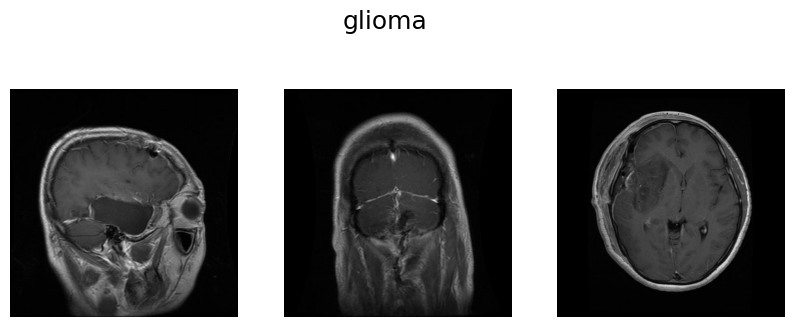

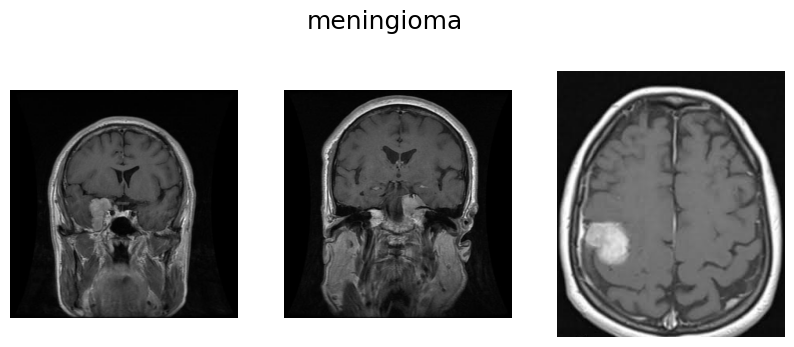

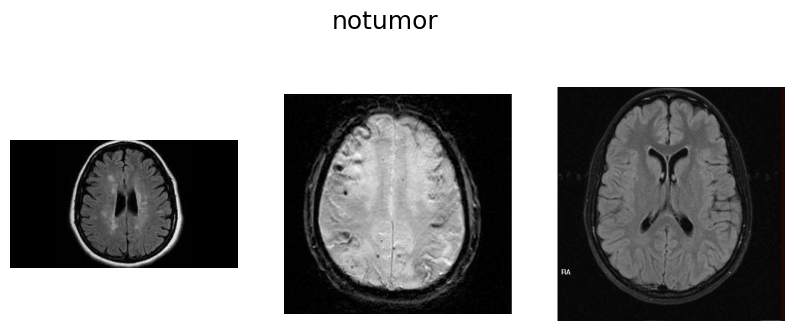

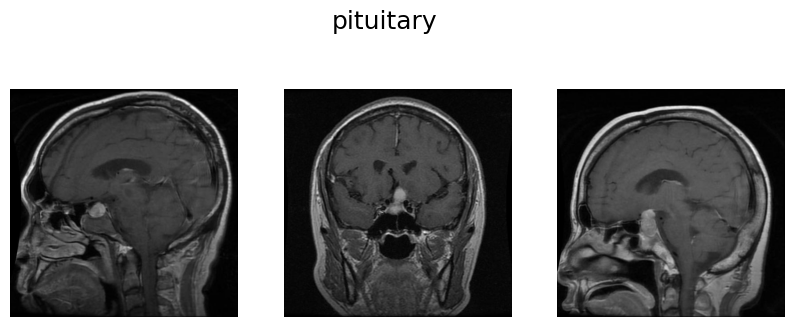

In [6]:
# displaying random 3 images from every category
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  images = os.listdir(path)

# Initialize a subplot with 1 row and 3 columns
  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  fig.suptitle(f'{category}', fontsize=18)

  for i in range(3):
      # Randomly select an image
      img_name = images[np.random.randint(0, len(images))]
      img_path = os.path.join(path, img_name)
      img_array = cv2.imread(img_path)

      # Display the image
      ax[i].imshow(img_array)
      ax[i].axis('off')

In [7]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))

In [8]:
img_array.shape

(512, 512, 3)

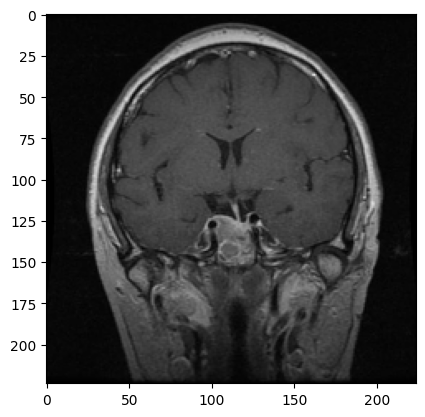

In [9]:
# vgg16 works with an image size of 224

IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)

In [10]:
new_array.shape

(224, 224, 3)

In [11]:
# creating the processed training data
# vgg16 works only with on RGB images

training_data = []

def create_training_data():
  for category in CATEGORIES:
    #building the path
    path = os.path.join(DATADIR, category)
    #Assigning labels
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

In [12]:
create_training_data()

In [13]:
# creating the input and target list
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

In [14]:
# converting the dtype from list to numpy array
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [15]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [16]:
print(f'X_train Length : {X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, X_train Channel Dimension : {X_train.shape[3]}')
print(f'X_test Length : {X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, X_test Channel Dimension : {X_test.shape[3]}')

X_train Length : 4569, X_train Image size : (224, 224), X_train Channel Dimension : 3
X_test Length : 1143, X_test Image size : (224, 224), X_test Channel Dimension : 3


In [17]:
# building vgg16 model with weights of 'imagenet' and excluding the top layers
vgg = vgg16.VGG16(weights= 'imagenet',
                  include_top = False,
                  input_shape = (IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
# freezing the pre-trained layers
for layer in vgg.layers:
  layer.trainable = False

In [19]:
# adding the head layers
def top_layers(bottom_model):
  head_model = bottom_model.output
  head_model = GlobalAveragePooling2D()(head_model)
  head_model = Dense(1024, activation = 'relu')(head_model)
  head_model = Dense(512, activation = 'relu')(head_model)
  head_model = Dense(4, activation = 'softmax')(head_model)
  return head_model

In [20]:
HEAD = top_layers(vgg)

model = Model(inputs = vgg.input, outputs = HEAD)

In [21]:
# vgg16 model architecture (Top Layers + Freezeed pre-trained layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
y_train.shape, y_test.shape

((4569,), (1143,))

In [23]:
#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
143/143 [==============================] - 33s 153ms/step - loss: 0.7109 - accuracy: 0.8212
Epoch 2/5
143/143 [==============================] - 17s 120ms/step - loss: 0.2415 - accuracy: 0.9085
Epoch 3/5
143/143 [==============================] - 17s 122ms/step - loss: 0.1703 - accuracy: 0.9370
Epoch 4/5
143/143 [==============================] - 17s 122ms/step - loss: 0.1205 - accuracy: 0.9556
Epoch 5/5
143/143 [==============================] - 17s 121ms/step - loss: 0.1059 - accuracy: 0.9621


In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

36/36 [==============================] - 10s 258ms/step - loss: 0.2105 - accuracy: 0.9291
Model Accuracy : 92.91338324546814


In [27]:
# first 5 true labels
y_test[:5]

array([1, 2, 0, 3, 3])

In [32]:
pred = np.argmax(model.predict(X_test), axis = -1)

36/36 [==============================] - 4s 118ms/step


In [33]:
# first 5 predicted labels
pred[:5]

array([1, 2, 0, 3, 3])

In [35]:
# classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.88       288
           1       0.80      0.95      0.87       265
           2       0.98      0.99      0.99       291
           3       0.96      0.98      0.97       299

    accuracy                           0.93      1143
   macro avg       0.93      0.93      0.93      1143
weighted avg       0.94      0.93      0.93      1143



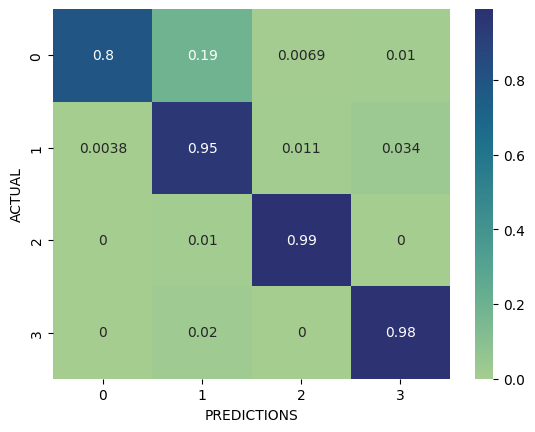

In [40]:
#confusion matrix
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest');
plt.xlabel('PREDICTIONS');
plt.ylabel('ACTUAL');

- 0 - glioma - Correct classification with 80% accuracy
- 1 - meningioma - Correct classification with 95% accuracy
- 2 - notumor - Correct classification with 99% accuracy
- 3 - pituitary - Correct classification with 98% accuracy